Le but de ce projet est de faire de la classification de tweets pour donner le sentiment qui sort du tweet qui va être posté.
Pour réaliser cette tâche, plusieurs étapes sont nécessaires :
1. Récupérer et nettoyer les tweets : après avoir récupéré les données, nous allons les nettoyer et les normaliser. Ici, nous utiliserons des méthodes de Tokenisation, de Stop-Word, de Lemmatisation et de Stemming.
2. Transformation des mots en vecteurs : le but est de créer pour chaque mot un vecteur (objet mathématique) facilement interprétable par le modèle. Ici, nous utiliserons le CountVectorizer.
3. L'étape de prédiction : c'est le moment où on créé et on entraine le modèle qui nous servira à prédire le sentiment des tweets. Ici, nous avons testé 3 modèles : le classificateur BernoulliNB, le classificateur LogReg et le classificateur LinearSVC.

## Context
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

In [1]:
import pandas as pd

# import csv
raw_data = pd.read_csv('data/training.1600000.processed.noemoticon.csv', encoding='latin-1', names=['target', 'ids', 'date', 'flag', 'user', 'text'])
raw_data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Content
It contains the following 6 fields:
1. target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
2. ids: The id of the tweet
3. date: the date of the tweet
4. flag: The query. If there is no query, then this value is NO_QUERY.
5. user: the user that tweeted
6. text: the text of the tweet

In [2]:
raw_data["target"].unique()

array([0, 4], dtype=int64)

In [3]:
data = raw_data.copy(deep=True)
data['target'] = data['target'].map(lambda x: 1 if x == 4 else 0).astype('bool')
data['ids'] = data['ids'].astype('str')
data['date'] = data['date'].astype('str') # We will convert them to date if useful later, now we just want to reduce the size of the dataframe
data['flag'] = data['flag'].astype('str')
data['user'] = data['user'].astype('str')
data['text'] = data['text'].astype('str')

In [4]:
for col in data.columns:
    print(col, data[col].dtype)
    print(data[col].head())
    print(data[col].value_counts())
    print('\n')

target bool
0    False
1    False
2    False
3    False
4    False
Name: target, dtype: bool
False    800000
True     800000
Name: target, dtype: int64


ids object
0    1467810369
1    1467810672
2    1467810917
3    1467811184
4    1467811193
Name: ids, dtype: object
2190457769    2
1972193428    2
1989776729    2
1989776908    2
1564543229    2
             ..
2197311196    1
2197311146    1
2197310899    1
2197310477    1
2193602129    1
Name: ids, Length: 1598315, dtype: int64


date object
0    Mon Apr 06 22:19:45 PDT 2009
1    Mon Apr 06 22:19:49 PDT 2009
2    Mon Apr 06 22:19:53 PDT 2009
3    Mon Apr 06 22:19:57 PDT 2009
4    Mon Apr 06 22:19:57 PDT 2009
Name: date, dtype: object
Mon Jun 15 12:53:14 PDT 2009    20
Fri May 29 13:40:04 PDT 2009    17
Fri May 22 05:10:17 PDT 2009    17
Mon Jun 15 13:39:50 PDT 2009    17
Fri Jun 05 14:13:07 PDT 2009    16
                                ..
Sun Jun 07 12:36:07 PDT 2009     1
Sun Jun 07 12:36:04 PDT 2009     1
Sun Jun 07 12:36:03 PDT

In order to do a regression on the text, we need to clean those tweets.

In [5]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
print(f"{len(stopwords)} stopwords in the original list")
[stopwords.remove(negative_word) for negative_word in ['t', 'against', 'no', 'nor', 'not', 'don', "don't", 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]]
print(f"{len(stopwords)} stopwords after removing the negative words")

179 stopwords in the original list
137 stopwords after removing the negative words


In [6]:
from nltk.stem import WordNetLemmatizer
import re

def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)    
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            #if word not in stopwordlist:
            if word not in stopwords:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)        
    return processedText

In [7]:
import time

def fit(model, X_train, Y_train):
    t = time.time()
    model.fit(X_train, Y_train)
    print(f"Training time: {time.time() - t}")

In [8]:
def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    return sentiment

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
import time

corpus = data['text']
t = time.time()
X = preprocess(corpus)
print(f"Preprocessing took {time.time()-t} seconds")

Y = data['target']

Preprocessing took 84.42789030075073 seconds


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
import time

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# Training the vectorizer on the training data
vectorizer = CountVectorizer(max_features=1000)
print("Fitting the vectorizer on the training data")
t = time.time()
vectorizer.fit(X_train)
print(f"Fitting took {time.time() - t} seconds")
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# Logistic Regression
logRegModel = LogisticRegression(penalty="elasticnet", solver='saga', max_iter=1000, l1_ratio=0.1, verbose=1)
print("Fitting Logistic Regression")
t = time.time()
logRegModel.fit(X_train, Y_train)
logRegTrainTime =  round(time.time() - t)

# BernoulliNB
BerNBModel = BernoulliNB(alpha = 2)
print("Fitting BernoulliNB")
t = time.time()
BerNBModel.fit(X_train, Y_train)
BerNBTrainTime = round(time.time() - t)

# LinearSVC
LinSVCModel = LinearSVC(verbose=1)
print("Fitting LinearSVC")
t = time.time()
LinSVCModel.fit(X_train, Y_train)
LinSVCTrainTime = round(time.time() - t)

Fitting the vectorizer on the training data
Fitting took 8.180415630340576 seconds
Fitting Logistic Regression


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 76 epochs took 291 seconds
Fitting BernoulliNB


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.8min finished


Fitting LinearSVC
[LibLinear]

c:\Users\barau\Documents\FormationOpenClassrooms\Projet7\D-tectez-les-Bad-Buzz-gr-ce-au-Deep-Learning\simpleEnv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, DetCurveDisplay, ConfusionMatrixDisplay


def evaluate_roc_det(Y_test, Y_pred, model):
    # two subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    ax_roc = axs[0]
    ax_det = axs[1]

    fig.suptitle(f'ROC and DET curves for {model}', fontsize=20)
    ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
    ax_det.set_title("Detection Error Tradeoff (DET) curves")

    DetCurveDisplay.from_predictions(Y_test, Y_pred, ax=ax_det)
    RocCurveDisplay.from_predictions(Y_test, Y_pred, ax=ax_roc)
    plt.gcf().set_facecolor('white')
    plt.show()
    

def evaluate_confusion_matrix(Y_test, Y_pred, threshold, ax = None):
    binary_pred = np.where(Y_pred > threshold, 1, 0)
    ConfusionMatrixDisplay.from_predictions(Y_test, binary_pred, ax=ax)

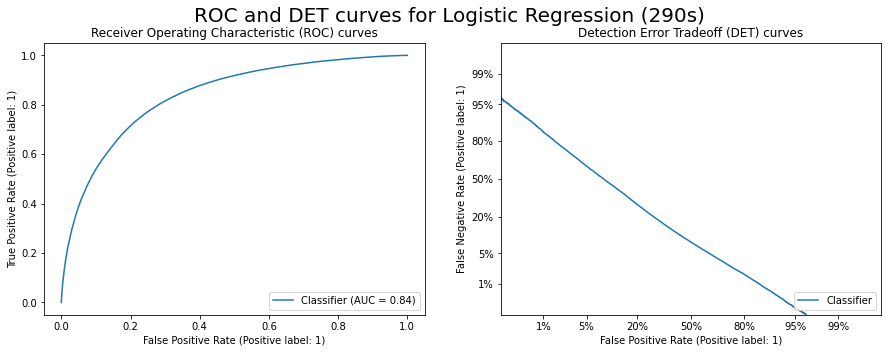

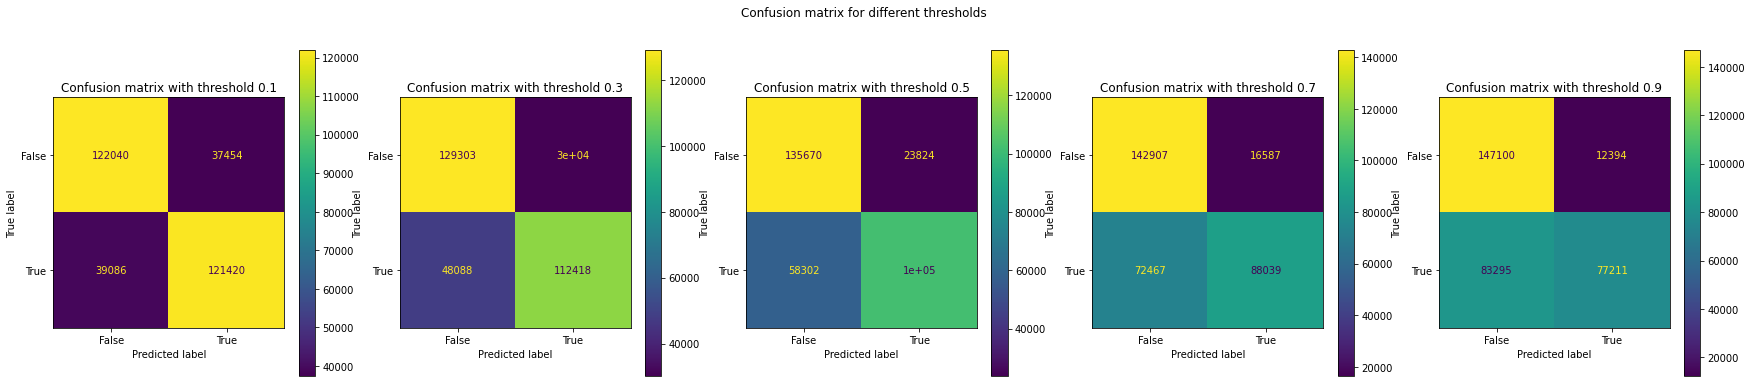

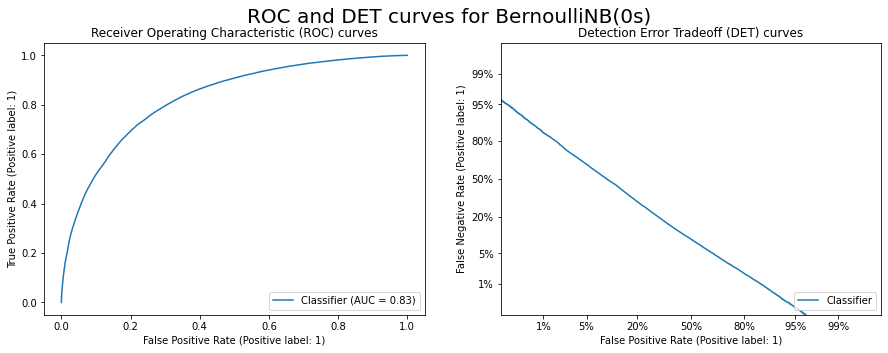

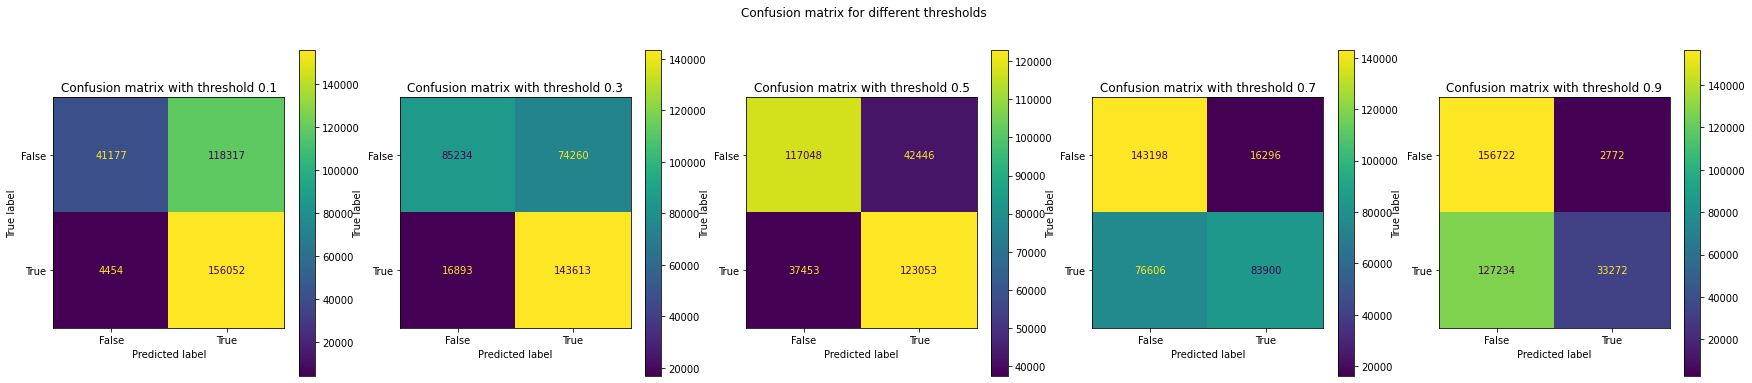

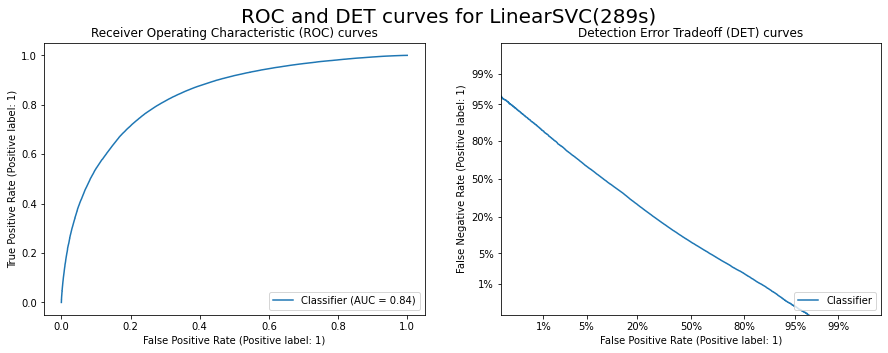

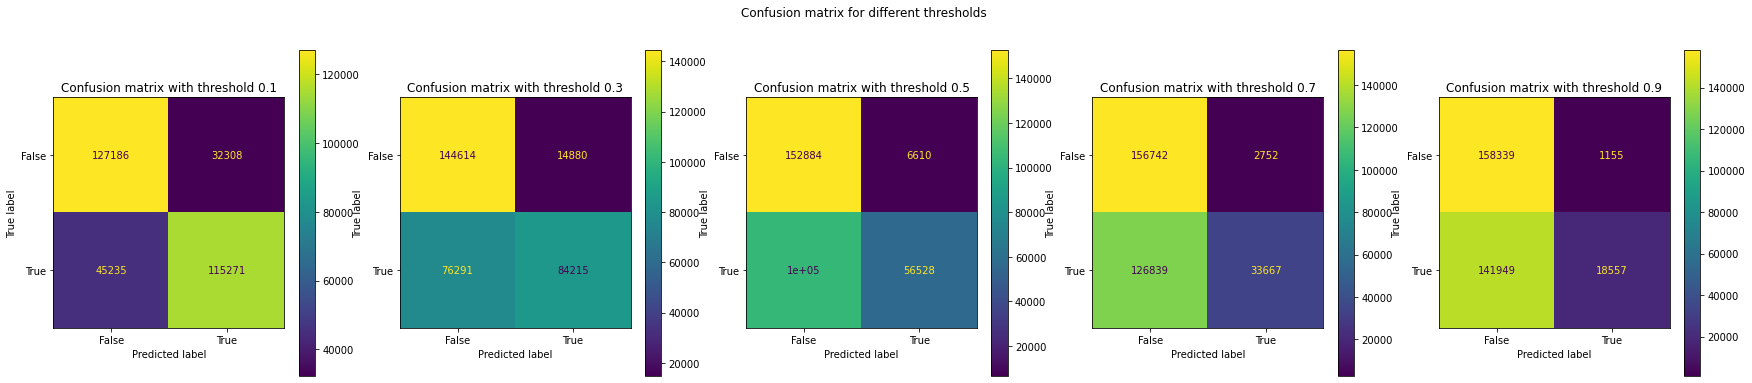

In [12]:
import numpy as np

logRegPred = logRegModel.decision_function(X_test)

BerNBPred = BerNBModel.predict_proba(X_test)[:,1]

LinSVCPred = LinSVCModel.decision_function(X_test)

for model, Y_pred in zip([f'Logistic Regression ({logRegTrainTime}s)', f'BernoulliNB({BerNBTrainTime}s)', f'LinearSVC({LinSVCTrainTime}s)'], [logRegPred, BerNBPred, LinSVCPred]):
    evaluate_roc_det(Y_test, Y_pred, model)

    possible_thresholds = np.linspace(0.1, 0.9, 5)
    fig, axs = plt.subplots(1, len(possible_thresholds), figsize=(6*len(possible_thresholds), 6))
    fig.suptitle("Confusion matrix for different thresholds")

    for threshold, ax in zip(possible_thresholds, axs.ravel()):
        evaluate_confusion_matrix(Y_test, Y_pred, threshold, ax = ax)
        ax.set_title(f"Confusion matrix with threshold {round(threshold, 1)}")
    plt.gcf().set_facecolor('white')
    plt.show()

Let's fine tune Naive Bayes classifier because it is by far the fastest model to fit.

In [14]:
from sklearn.model_selection import GridSearchCV, cross_val_score

BernoulliNB_param_grid = {
    'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
    'binarize': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
    'fit_prior': [True, False],
    }

grid_search = GridSearchCV(BerNBModel, BernoulliNB_param_grid, n_jobs = -1, cv=5, scoring='roc_auc')
grid_search.fit(X_train, Y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
tunedBernModel = grid_search.best_estimator_

{'alpha': 1, 'binarize': 0.1, 'fit_prior': True}
0.8264502298139478


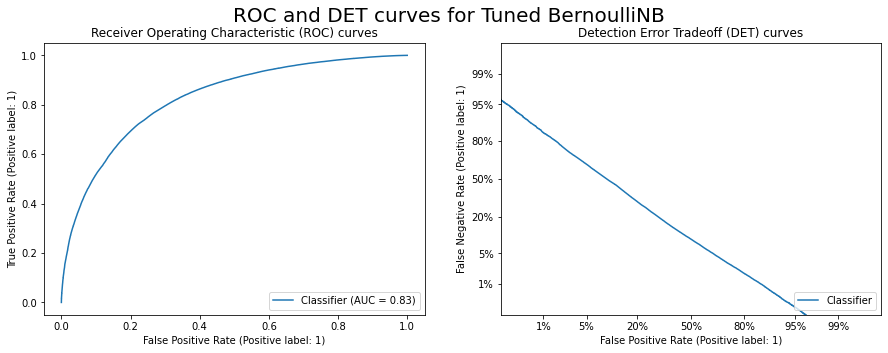

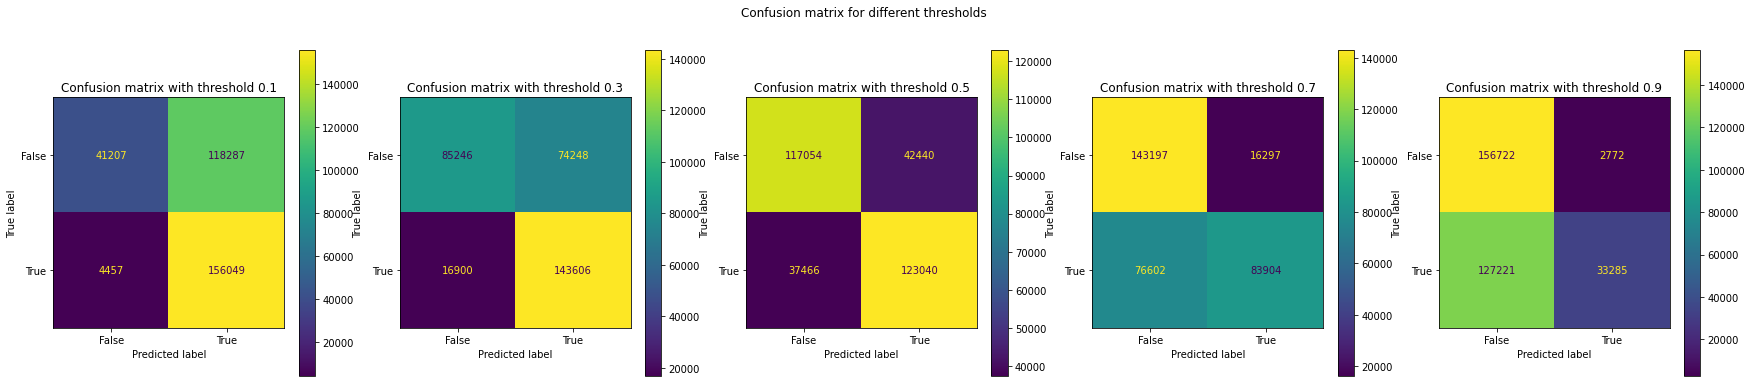

In [17]:
Y_pred = tunedBernModel.predict_proba(X_test)[:,1]

evaluate_roc_det(Y_test, Y_pred, "Tuned BernoulliNB")

possible_thresholds = np.linspace(0.1, 0.9, 5)
fig, axs = plt.subplots(1, len(possible_thresholds), figsize=(6*len(possible_thresholds), 6))
fig.suptitle("Confusion matrix for different thresholds")

for threshold, ax in zip(possible_thresholds, axs.ravel()):
    evaluate_confusion_matrix(Y_test, Y_pred, threshold, ax = ax)
    ax.set_title(f"Confusion matrix with threshold {round(threshold, 1)}")
plt.gcf().set_facecolor('white')
plt.show()

No significant improvement in AUC.

Let's analyse what are the decisive weights/words for linear SVC.

In [16]:
# Getting the index of the 10 best coefs
ind = np.argpartition(LinSVCModel.coef_[0], -10)[-10:]
sorted_ind = np.flip(ind[np.argsort(LinSVCModel.coef_[0][ind])])
vectorizer_features = vectorizer.get_feature_names_out()
important_words = [vectorizer_features[word_coef] for word_coef in sorted_ind]
print(f"The 10 most important words for positive tweets are:")
print(important_words)

# Same for the words that are the most decisive for negative tweets
ind = np.argpartition(LinSVCModel.coef_[0], 10)[:10]
sorted_ind = np.flip(ind[np.argsort(LinSVCModel.coef_[0][ind])])
vectorizer_features = vectorizer.get_feature_names_out()
important_words = [vectorizer_features[word_coef] for word_coef in sorted_ind]
print(f"The 10 most important words for negative tweets are:")
print(important_words)

The 10 most important words for positive tweets are:
['smile', 'worry', 'proud', 'welcome', 'thank', 'loving', 'congrats', 'goodnight', 'excited', 'thanks']
The 10 most important words for negative tweets are:
['upset', 'miss', 'missing', 'died', 'disappointed', 'poor', 'unfortunately', 'bummed', 'sadly', 'sad']
